# Predicting NO2 Concentration in Air
### Dataset
Air Quality Dataset from UC Irvine Machine Learning Repository

Link: https://archive.ics.uci.edu/dataset/360/air+quality

This time-series dataset comprises hourly records from five metal oxide chemical sensors monitoring air quality in an Italian city over one year (March 2004 to February 2005). It captures hourly average concentrations of CO, hydrocarbons, benzene, NOx, and NO2(Nitrogen Dioxide). Given Nitrogen Dioxide's impact on human health, our primary focus is on tracking its concentration. In this notebook, we will develop a VAR model to predict NO2 levels in sensors.

### 1. Import Libraries

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Utilities import train_and_save_model, load_and_test_model

### 2. Load Data

In [2]:
df = pd.read_excel('../../Data/Updated_AirQualityUCI.xlsx')

In [3]:
df.shape

(9357, 20)

In [4]:
df.head()

,DateTime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),log_C6H6(GT),sqrt_C6H6(GT),PT08.S2(NMHC),log_PT08.S2(NMHC),sqrt_PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),log_PT08.S4(NO2),sqrt_PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,0.211864,0.511849,0.120981,0.184498,0.169319,0.429532,0.361737,0.308761,0.601446,0.111036,0.311024,0.328694,0.513040,0.414121,0.716268,0.454654,0.333333,0.499057,0.280046
1,2004-03-10 19:00:00,0.161017,0.463196,0.120981,0.145428,0.135778,0.381350,0.312167,0.271680,0.558719,0.068382,0.360796,0.266509,0.453125,0.373716,0.673146,0.326382,0.326882,0.484287,0.264279
2,2004-03-10 20:00:00,0.177966,0.542011,0.120981,0.139148,0.130281,0.373026,0.303701,0.265207,0.551090,0.087339,0.346500,0.331655,0.451214,0.372400,0.671725,0.370588,0.296774,0.563168,0.276374
3,2004-03-10 21:00:00,0.177966,0.522980,0.120981,0.142780,0.133464,0.377863,0.308617,0.268971,0.555533,0.115098,0.326168,0.355345,0.464366,0.381422,0.681444,0.426741,0.277419,0.638906,0.294198
4,2004-03-10 22:00:00,0.127119,0.448833,0.120981,0.100156,0.095452,0.316475,0.247030,0.220765,0.497021,0.087339,0.374034,0.337578,0.422212,0.352214,0.649779,0.386228,0.280645,0.633564,0.295215


In [5]:
df.dtypes

DateTime              datetime64[ns]
CO(GT)                       float64
PT08.S1(CO)                  float64
NMHC(GT)                     float64
C6H6(GT)                     float64
log_C6H6(GT)                 float64
sqrt_C6H6(GT)                float64
PT08.S2(NMHC)                float64
log_PT08.S2(NMHC)            float64
sqrt_PT08.S2(NMHC)           float64
NOx(GT)                      float64
PT08.S3(NOx)                 float64
NO2(GT)                      float64
PT08.S4(NO2)                 float64
log_PT08.S4(NO2)             float64
sqrt_PT08.S4(NO2)            float64
PT08.S5(O3)                  float64
T                            float64
RH                           float64
AH                           float64
dtype: object

The data types for all numeric values are correct. 

Also, top 2 correlated variables PT08.S2(NMHC) and C6H6(GT) are normalized and tranformed for modelling. So, we will train, test and evaluate VAR which is a multivariate model in this notebook.

##### Data:

CO(GT), NMHC(GT), C6H6(GT), NOx(GT) and NO2(GT) are ground truth values of these gases in air.

PT08.S1(CO), PT08.S2(NMHC), PT08.S3(NOx), PT08.S4(NO2) and PT08.S5(O3) are sensored responses values.

T is Temperature of the air

RH is Relative Humidity in the air

AH is Absolute Humidity in the air

Our main focus is to predict NO2 gas concentation according to sesored responses in air, i.e. PT08.S4(NO2)

### 3. Model
#### 3.1. Preparing data

In [6]:
# Selecting target and top correlated features
df_model_log = df[['log_PT08.S4(NO2)', 'log_PT08.S2(NMHC)', 'log_C6H6(GT)']].dropna()

# Train-test split (80-20 split)
train_size = int(len(df_model_log) * 0.8)
train_data_log, test_data_log = df_model_log.iloc[:train_size], df_model_log.iloc[train_size:]

# Save train and test splits to CSV
train_data_log.to_csv("../../Data/var_log_train_data.csv", index=True)
test_data_log.to_csv("../../Data/var_log_test_data.csv", index=True)

In [7]:
# Selecting target and top correlated features
df_model_sqrt = df[['sqrt_PT08.S4(NO2)', 'sqrt_PT08.S2(NMHC)', 'sqrt_C6H6(GT)']].dropna()

# Train-test split (80-20 split)
train_size = int(len(df_model_sqrt) * 0.8)
train_data_sqrt, test_data_sqrt = df_model_sqrt.iloc[:train_size], df_model_sqrt.iloc[train_size:]

# Save train and test splits to CSV
train_data_sqrt.to_csv("../../Data/var_sqrt_train_data.csv", index=True)
test_data_sqrt.to_csv("../../Data/var_sqrt_test_data.csv", index=True)

#### 3.2. Training VAR model

In [8]:
target_columns_log = ["log_PT08.S4(NO2)", "log_PT08.S2(NMHC)", "log_C6H6(GT)"]
model_log = train_and_save_model(train_data_log, target_columns_log, model_path="var_model_log.pkl")

Model trained and saved at var_model_log.pkl


In [9]:
target_columns_sqrt = ["sqrt_PT08.S4(NO2)", "sqrt_PT08.S2(NMHC)", "sqrt_C6H6(GT)"]
model_sqrt = train_and_save_model(train_data_sqrt, target_columns_sqrt, model_path="var_model_sqrt.pkl")

Model trained and saved at var_model_sqrt.pkl


#### 3.3. Testing and Evaluation VAR model

In [10]:
predictions_log, metrics_log = load_and_test_model(test_data_log, target_column=target_columns_log, model_path="var_model_log.pkl")

RMSE: 0.11759308279279361
MAE: 0.09977379262973518


In [11]:
predictions_sqrt, metrics_sqrt = load_and_test_model(test_data_sqrt, target_column=target_columns_sqrt, model_path="var_model_sqrt.pkl")

RMSE: 0.1596523723017971
MAE: 0.13105794168987692


#### 3.4. Plotting

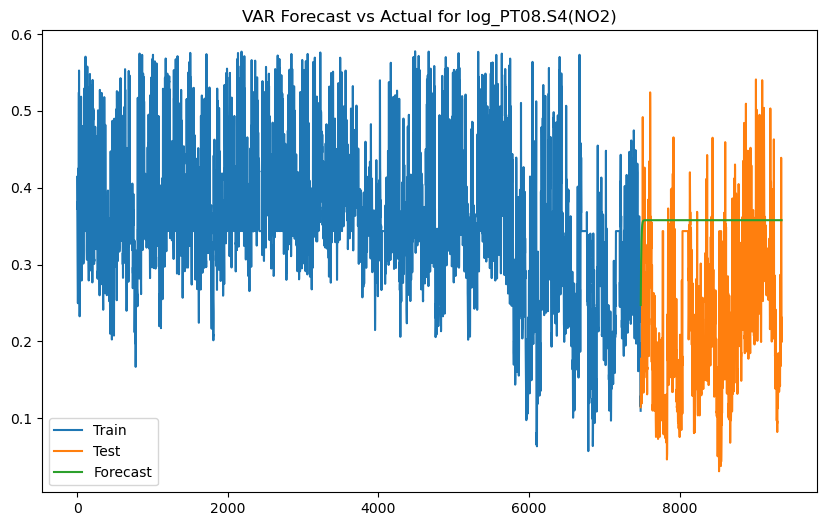

In [12]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_data_log['log_PT08.S4(NO2)'], label='Train')
plt.plot(test_data_log['log_PT08.S4(NO2)'], label='Test')
plt.plot(predictions_log['log_PT08.S4(NO2)'], label='Forecast')
plt.legend()
plt.title('VAR Forecast vs Actual for log_PT08.S4(NO2)')
plt.show()

Log feature transforms gives better model performance than Square root feature transform

Considering the RMSE and MAE evaluation metrics, the model is currently performing at a satisfactory level. 

However, to achieve optimal accuracy and robustness, additional iterations with feature engineering and hyperparameter tuning are recommended. This could involve experimenting with feature selection, transformation, and scaling techniques that address the model's sensitivity to skewed and non-uniform data distributions. Such refinements can help improve predictive power and ensure the model generalizes better across diverse data scenarios. Through these adjustments, we can enhance model performance to reach a higher standard of reliability and accuracy.